In [5]:
%reset
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import pickle
X = pickle.load(open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images.pkl"), "rb" ) )
titles = pd.Series(X[1])
X = X[0]

In [8]:
y = np.hstack([np.ones(len(X)//2),np.zeros(len(X)//2)]).astype(int)

In [9]:
i_range = np.arange(y.shape[0])

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X, y, i_range, test_size=0.2, random_state=0, stratify=y)

In [11]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((320, 646, 646, 3), (80, 646, 646, 3), (320,), (80,))

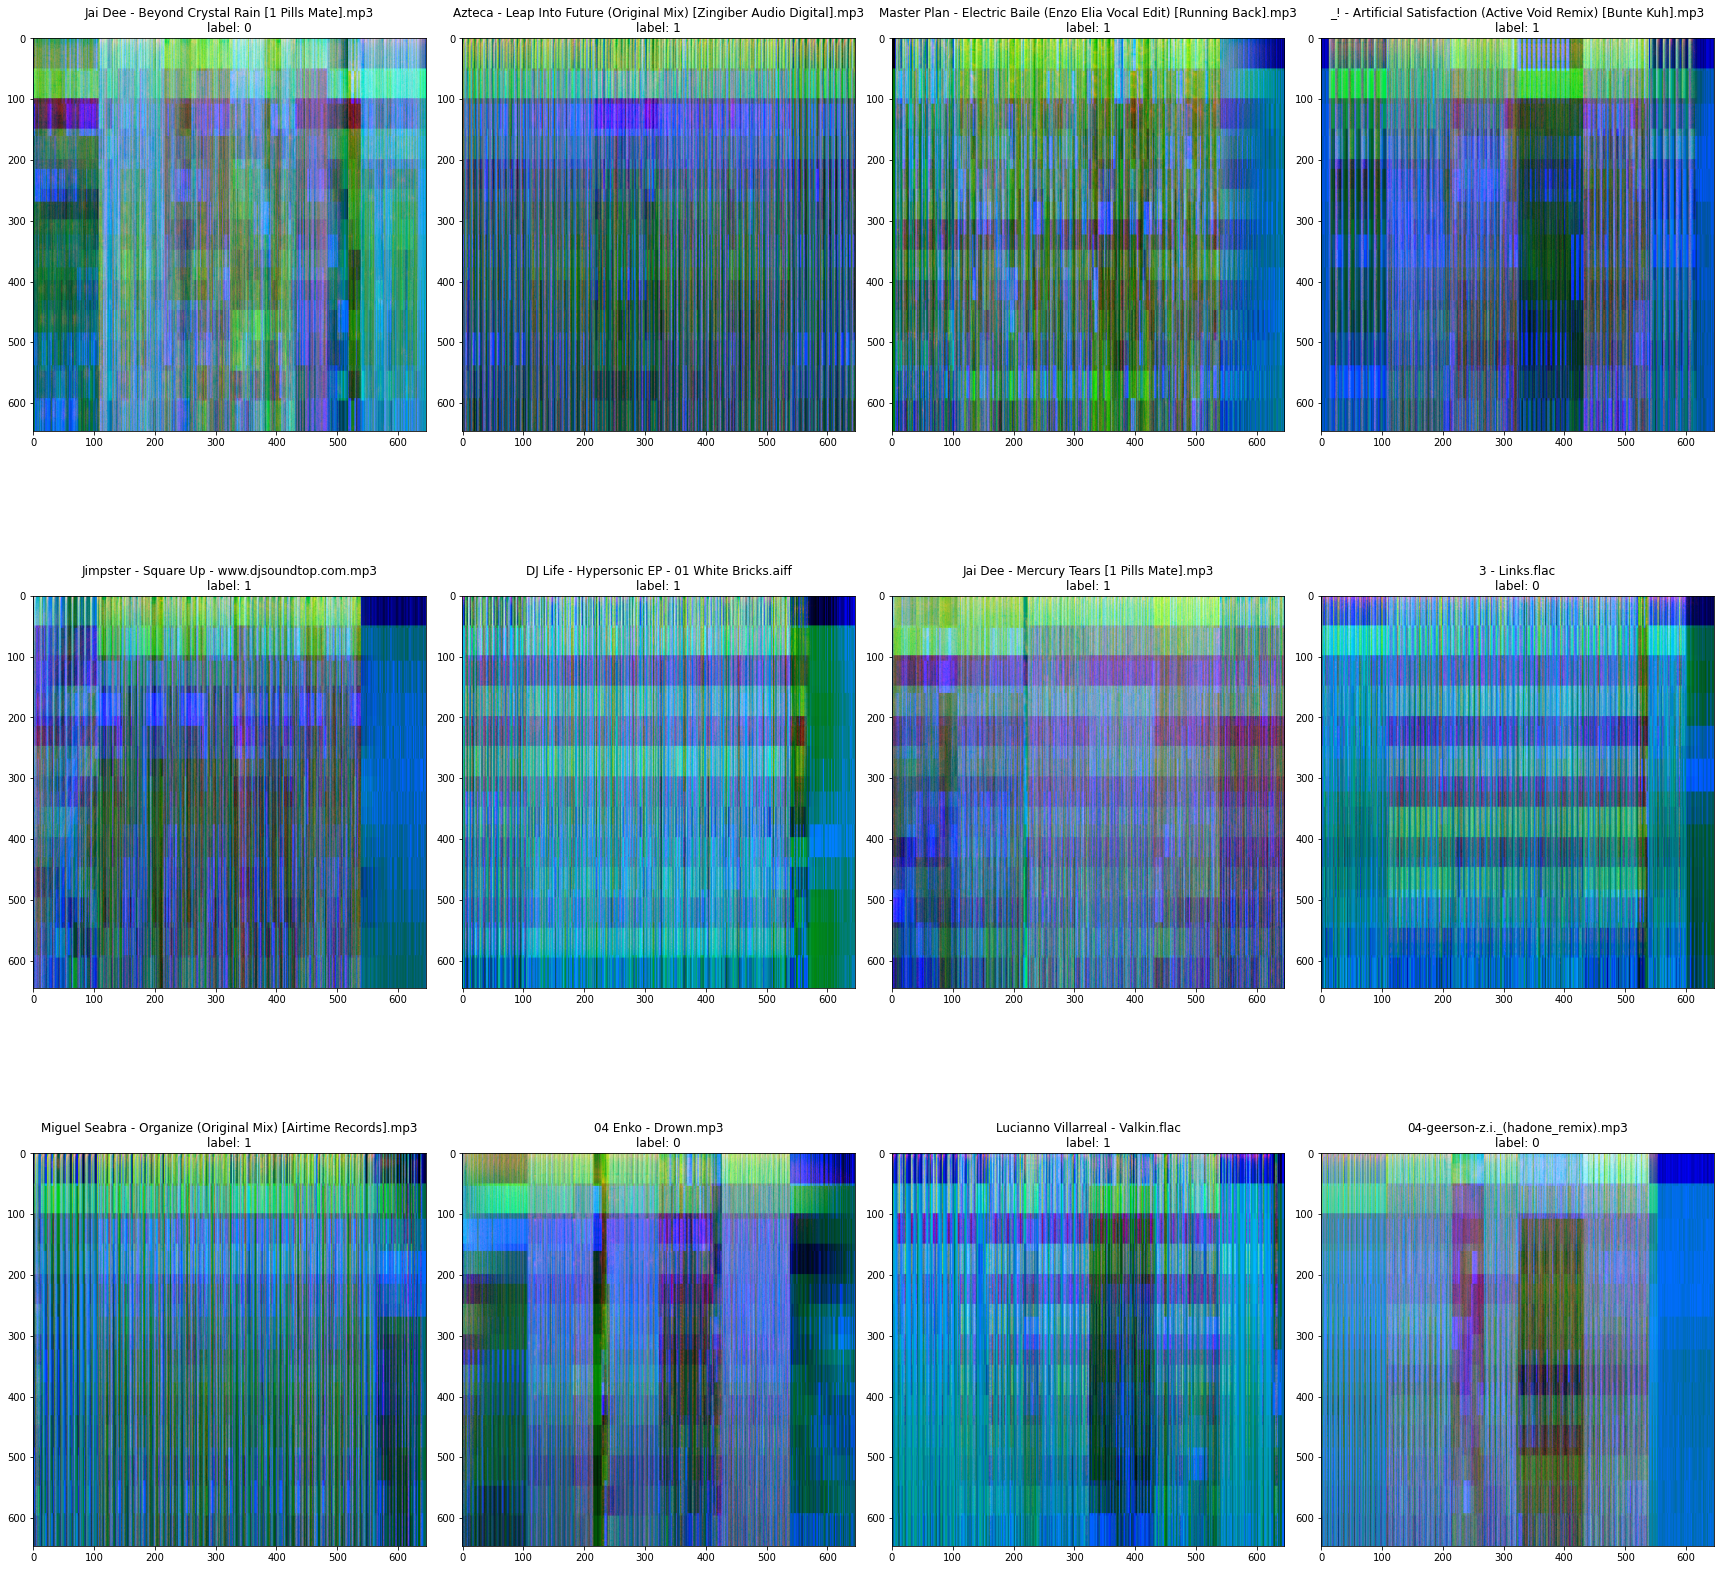

In [12]:
images = np.random.choice(range(X.shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(24, 24))
for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.imshow(X[images[i-1]])
    plt.title(f"{titles[images[i-1]]}\nlabel: {y[images[i-1]]}")
plt.tight_layout()
plt.show()

In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 3)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 3)

In [14]:
X_train.shape[1:]

(646, 646, 3)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

def lenet5():
    model = Sequential()
    # Layer C1
    model.add(BatchNormalization(input_shape=(X_train.shape[1:])))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
    # Layer S2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
    # Layer S2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Before going into layer C5, we flatten our units
    model.add(Dropout(0.05))
    model.add(Flatten())
    # Layer C5
    model.add(Dense(units=256, activation='relu'))
    # Layer F6
    model.add(Dense(units=128, activation='relu'))
    # Output layer
    model.add(Dense(units=1, activation = 'sigmoid'))
    return model

my_model = lenet5()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
my_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=30),
            TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)]
my_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_5 (Batc  (None, 646, 646, 3)      12        
 hNormalization)                                                 
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 215, 215, 3)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 213, 213, 16)      448       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 106, 106, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 104, 104, 32)      4640      
                                                      

In [23]:
BATCH_SIZE = 32

my_model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test),
    batch_size=BATCH_SIZE, 
    epochs=30, 
    callbacks=callbacks)

Epoch 1/30
10/10 [==============================] - 20s 2s/step - loss: 2.5020 - accuracy: 0.5094 - val_loss: 0.4885 - val_accuracy: 0.7750
Epoch 2/30
10/10 [==============================] - 21s 2s/step - loss: 0.8116 - accuracy: 0.6500 - val_loss: 1.5340 - val_accuracy: 0.5375
Epoch 3/30
10/10 [==============================] - 24s 2s/step - loss: 0.4332 - accuracy: 0.8000 - val_loss: 0.9763 - val_accuracy: 0.5750
Epoch 4/30
10/10 [==============================] - 25s 2s/step - loss: 0.3364 - accuracy: 0.8687 - val_loss: 0.4493 - val_accuracy: 0.8250
Epoch 5/30
10/10 [==============================] - 24s 2s/step - loss: 0.2287 - accuracy: 0.9344 - val_loss: 0.7639 - val_accuracy: 0.6500
Epoch 6/30
10/10 [==============================] - 25s 2s/step - loss: 0.1280 - accuracy: 0.9781 - val_loss: 0.7565 - val_accuracy: 0.7000
Epoch 7/30
10/10 [==============================] - 21s 2s/step - loss: 0.0760 - accuracy: 0.9906 - val_loss: 0.9132 - val_accuracy: 0.6750
Epoch 8/30
10/10 [==

In [24]:
from sklearn.metrics import f1_score, confusion_matrix

y_pred = my_model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1,0).reshape(y_pred.shape[0])

loss, metric = my_model.evaluate(X_test, y_test, verbose=0)

print('loss is:', loss)
print('accu is:', metric)
print("f1_score is:",f1_score(y_test, y_pred))

loss is: 0.46653252840042114
accu is: 0.925000011920929
f1_score is: 0.9230769230769231


[]

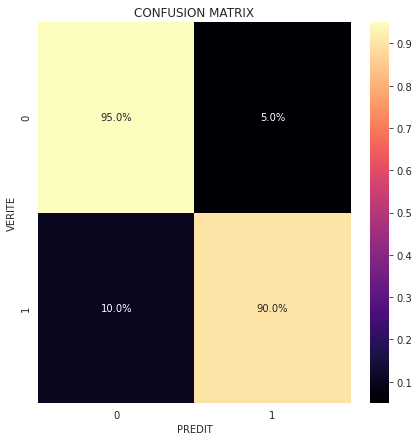

In [25]:
conf = confusion_matrix(y_test, y_pred, normalize="true")
plt.figure(figsize=(7,7))
sns.set_style(style='whitegrid')
heat = sns.heatmap(conf, annot=True, cmap="magma", fmt = ".1%")
heat.set(xlabel="PREDIT", ylabel="VERITE", title="CONFUSION MATRIX")
plt.plot()

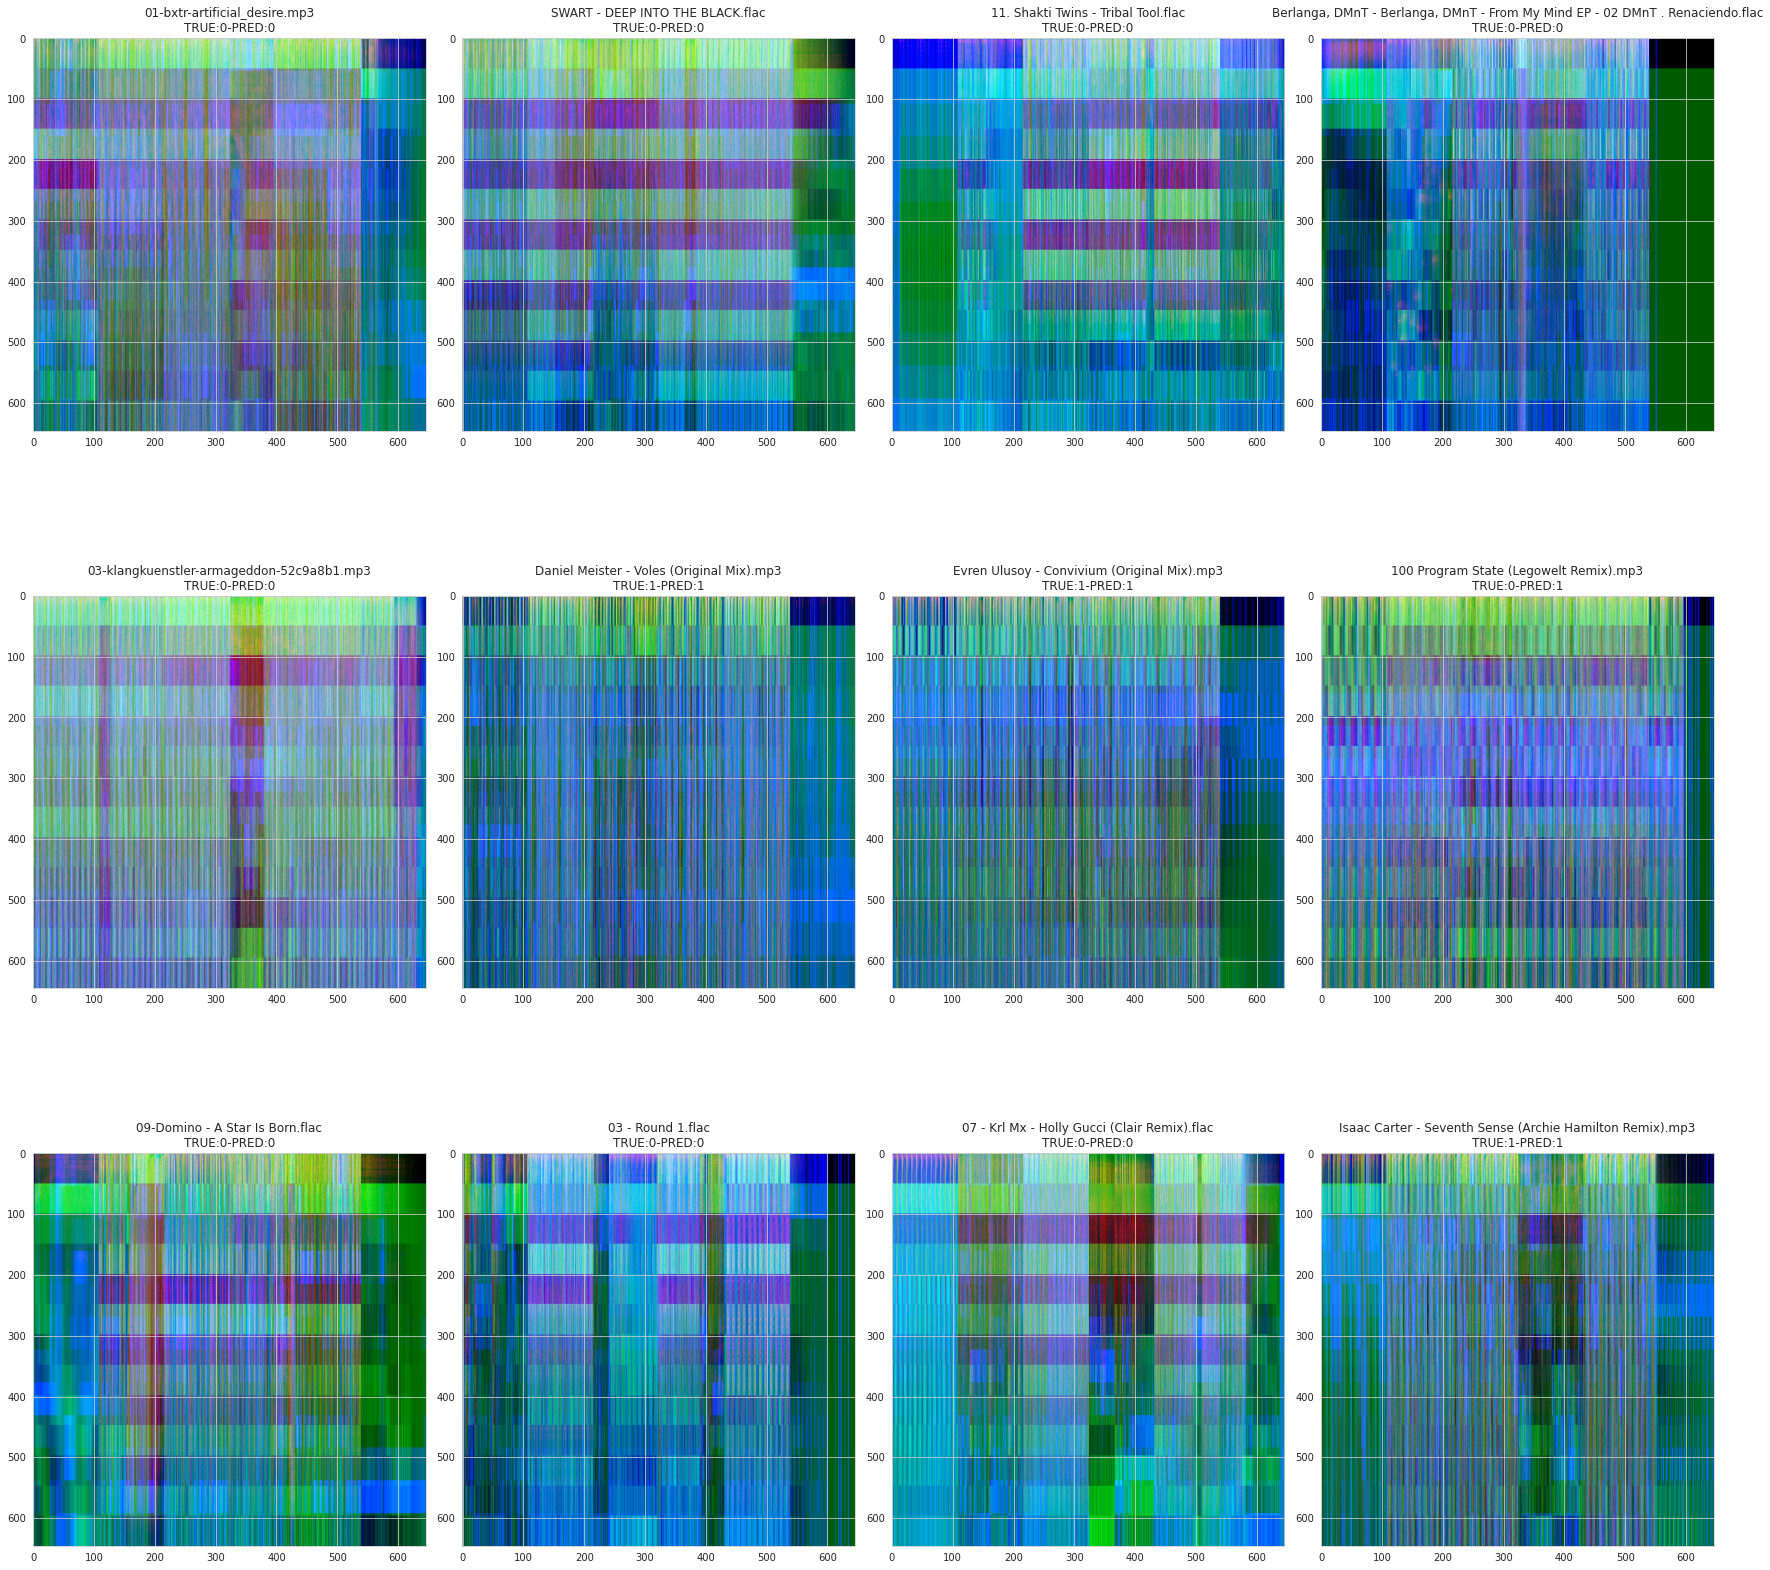

In [27]:
images = np.random.choice(range(X_test.shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(24, 24))
for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.imshow(X_test[images[i-1]])
    plt.title(f"{titles[i_test[images[i-1]]]}\nTRUE:{y_test[images[i-1]]}-PRED:{y_pred[images[i-1]]}")
    plt.
plt.tight_layout()
plt.show()